# Linear Regression Illustrated with Tensorflow

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import tensorflow as tf

2023-01-31 10:29:27.674058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data for Modeling
Below, we'll train models using some real automotive data. Here we'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile) from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

### Step 1: Load the Data
Load the data using the column names from [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

In [2]:
# Provide the names for the feature columns since the CSV file with the data does not have a header row
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data from a CSV file into a pandas dataframe
car_data = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

# Display dataset
display(car_data)

,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


### Step 2: Randomize the Data
We'll use SGD (Stochastic Gradient Descent) for training. This means it's important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

In [3]:
# Shuffle the order of the rows without touching the columns
# Get a list of indices corresponding to the rows
indices = np.arange(car_data.shape[0])
print('indices:', indices, '\n')

# Shuffle the indices using np.random.permutation - set a random seed for replicability
np.random.seed(0)
shuffled_indices = np.random.permutation(indices)
print('shuffled indices:', shuffled_indices, '\n')

# Use dataframe.reindex to change the ordering of the original dataframe
car_data = car_data.reindex(shuffled_indices)
display(car_data)

# This could also be done in one line...
# car_data = car_data.reindex(np.random.permutation(car_data.shape[0]))

indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204] 

shuffled indices: [ 52 181   5  18 188 170  76 154 104  33  12 129  55  66  45 169 130   7
  37 152  80 111 131 171 179 138 156 113 161  89 183 193 125 173 

,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
52,1,104,mazda,gas,std,two,hatchback,fwd,front,93.1,...,91,2bbl,3.03,3.15,9.0,68,5000,31,38,6795
181,-1,?,toyota,gas,std,four,wagon,rwd,front,104.5,...,161,mpfi,3.27,3.35,9.2,156,5200,19,24,15750
5,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
18,2,121,chevrolet,gas,std,two,hatchback,fwd,front,88.4,...,61,2bbl,2.91,3.03,9.5,48,5100,47,53,5151
188,2,94,volkswagen,gas,std,four,sedan,fwd,front,97.3,...,109,mpfi,3.19,3.40,10.0,100,5500,26,32,9995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-1,93,mercedes-benz,diesel,turbo,four,sedan,rwd,front,110.0,...,183,idi,3.58,3.64,21.5,123,4350,22,25,25552
192,0,?,volkswagen,diesel,turbo,four,sedan,fwd,front,100.4,...,97,idi,3.01,3.40,23.0,68,4500,33,38,13845
117,0,161,peugot,gas,turbo,four,sedan,rwd,front,108.0,...,134,mpfi,3.61,3.21,7.0,142,5600,18,24,18150
47,0,145,jaguar,gas,std,four,sedan,rwd,front,113.0,...,258,mpfi,3.63,4.17,8.1,176,4750,15,19,32250


### Step 3: Select Features for Modeling
To keep things simple, we will keep just a few of the 26 columns. Since the values come as strings, we need to convert them to floats. Also, we remove examples (rows) that have some missing value(s) of the columns we care about.

Note: There are various ways to deal with missing features. Dropping examples with any missing feature is not ideal, but is a simple strategy to test here.

In [4]:
# Choose a subset of columns (these are all numeric).
columns = ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
car_data = car_data[columns]

# Convert strings to numeric values, coercing missing values to NaN
for column in columns:
    car_data[column] = pd.to_numeric(car_data[column], errors='coerce')

# Drops rows with missing value(s)
car_data = car_data.dropna()

# Should yield 199 rows
display(car_data)

,horsepower,peak-rpm,city-mpg,highway-mpg,price
52,68.0,5000.0,31,38,6795.0
181,156.0,5200.0,19,24,15750.0
5,110.0,5500.0,19,25,15250.0
18,48.0,5100.0,47,53,5151.0
188,100.0,5500.0,26,32,9995.0
...,...,...,...,...,...
67,123.0,4350.0,22,25,25552.0
192,68.0,4500.0,33,38,13845.0
117,142.0,5600.0,18,24,18150.0
47,176.0,4750.0,15,19,32250.0


### Step 4: Train/Test Set Split
Now that we've shuffled the order of rows, we can split the data into two subgroups:
1. A **training** set
2. A **test (hold-out)** set

We'll avoid looking at the test data.

We're going to train models that **predict price from the other columns**, so we'll create separate variables for input and output data.

In [5]:
# Select key model features
features = ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']

# Use an ~80%/20% train/test split - manually coded based on row indices rather than scikit-learn
car_train = car_data[:160]
car_test = car_data[160:]

# Create separate variables for features (inputs) and labels (outputs)
car_train_features = car_train[features]
car_test_features = car_test[features]
car_train_labels = car_train['price']
car_test_labels = car_test['price']

# Confirm data shapes are as expected
print('train data shape:', car_train_features.shape)
print('train labels shape:', car_train_labels.shape)
print('test data shape:', car_test_features.shape)
print('test labels shape:', car_test_labels.shape)

train data shape: (160, 4)
train labels shape: (160,)
test data shape: (39, 4)
test labels shape: (39,)


### Step 5: Establish a Baseline

Now that we have test data, we can evaluate a baseline. We'll use the average price of cars in the training set as our baseline -- that is, the baseline always predicts the average price regardless of the input. Instead of MSE, we'll use **RMSE** (root mean squared error, the square root of the MSE) as our evaluation metric.

We'll proceed to:
1. Implement this baseline.
2. Compute the RMSE of the baseline on both the train and test data.
3. Examine whether the test RMSE is larger or smaller than the train RMSE.

In [6]:
# Create function for baseline model (average of price in training dataset)
def average_baseline(x):
    """Define a baseline model that always predicts the average price of cars in the training dataset.
    
    Args:
    x: a dataframe where each column is an input feature and each row is a training example

    Returns:
    avg_price: the average price of a car
    """
    avg_price = x["price"].mean()
    return avg_price

# Apply baseline model calculated values to training and test datasets
car_train["average_baseline_price"] = average_baseline(car_train)
car_test["average_baseline_price"] = average_baseline(car_train)

# Display first 10 rows of updated training dataset with baseline model implemented to check for accuracy
print("Displaying snippet of updated training dataset with baseline model implemented \
(average baseline price = 13064.675):")
display(car_train.head(10))
print("\n=======================================================================================\n")

# Create function for RMSE (root mean squared error)
def RMSE(true_values, predicted_values):
    """Return the RMSE between true values and model-predicted values.
    
    Args:
    true_values: target outputs
    predicted_values: model-generated values
    
    Returns:
    RMSE_val: the RMSE value
    """
    RMSE_val = round(np.sqrt(np.mean(np.square(np.subtract(true_values, predicted_values)))), 10)
    return RMSE_val

# Compute RMSE of baseline model on both training and test datasets
print("RMSE for baseline model -- TRAINING DATASET:")
display(RMSE(car_train["price"], car_train["average_baseline_price"]))
print("RMSE for baseline model -- TEST DATASET:")
display(RMSE(car_test["price"], car_test["average_baseline_price"]))

Displaying snippet of updated training dataset with baseline model implemented (average baseline price = 13064.675):


/var/folders/8p/70n8s0n94xq5btk8hg6g4n3c0000gn/T/ipykernel_2108/946260273.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_train["average_baseline_price"] = average_baseline(car_train)
/var/folders/8p/70n8s0n94xq5btk8hg6g4n3c0000gn/T/ipykernel_2108/946260273.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_test["average_baseline_price"] = average_baseline(car_train)


,horsepower,peak-rpm,city-mpg,highway-mpg,price,average_baseline_price
52,68.0,5000.0,31,38,6795.0,13064.675
181,156.0,5200.0,19,24,15750.0,13064.675
5,110.0,5500.0,19,25,15250.0,13064.675
18,48.0,5100.0,47,53,5151.0,13064.675
188,100.0,5500.0,26,32,9995.0,13064.675
170,116.0,4800.0,24,30,11199.0,13064.675
76,68.0,5500.0,37,41,5389.0,13064.675
154,62.0,4800.0,27,32,7898.0,13064.675
104,160.0,5200.0,19,25,17199.0,13064.675
33,76.0,6000.0,30,34,6529.0,13064.675




RMSE for baseline model -- TRAINING DATASET:


7946.598808256

RMSE for baseline model -- TEST DATASET:


8018.0007772885

The RMSE for the test dataset is only slightly larger (<1% larger) than the RMSE for the training dataset. However, this isn't outside of my expectations. I'd expect the two RMSEs to be reasonably similar, since the original dataset was randomized before portions were allocated into training and test datasets (a process which helps to minimize the chance of any bias from the original order of data records carrying over to the split datasets and makes the split datasets "representative"). Two RMSEs that are within 1% of each other seem reasonably similar.

I'd imagine that the test dataset has a slightly higher RMSE because 1) it contains fewer records and 2) the baseline model is applying the average `price` from the training dataset across *both* the training and test datasets in the RMSE calculation. For those reasons, it's not surprising to see some slightly differently-sized deviations in the error calculations –– i.e., the squared differences between the actual `price` (true value) and average `price` (model-predicted value) –– across the two split datasets, and it's also not surprising that a training set-based average would have a slightly larger error when applied against the test set due to typical model limitations when generalizing from observed data to new unobserved data.

### Step 6: Plot Feature Histograms
It's hard to stare at a matrix of 160x5 numbers (the shape of our training data) and know what to make of it! So, we'll plot feature histograms to build some intuition about the data. This gives us a sense of the distribution of each feature, but not how the features relate to each other.

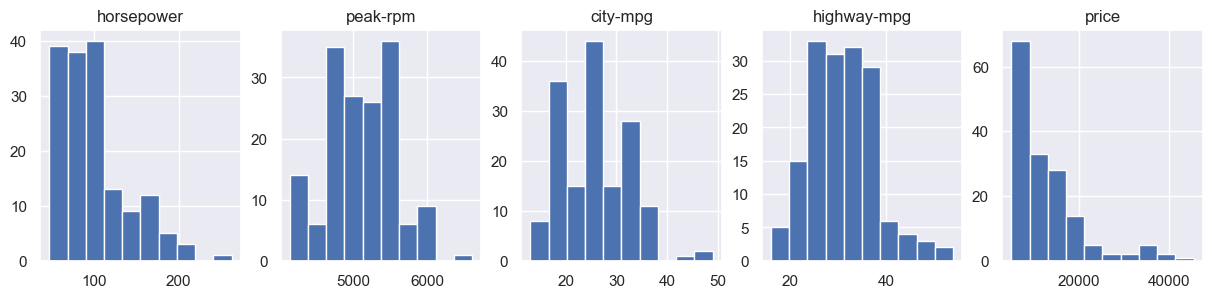

,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,160.000000,160.000000,160.000000,160.000000,160.000000
mean,101.468750,5105.625000,25.493750,31.025000,13064.675000
std,38.227542,467.059162,6.649346,7.106512,7971.548944
min,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,70.000000,4800.000000,19.000000,25.000000,7609.000000
50%,93.000000,5100.000000,25.000000,30.500000,10320.000000
75%,115.250000,5500.000000,31.000000,37.000000,16500.000000
max,262.000000,6600.000000,49.000000,54.000000,45400.000000


In [7]:
plt.figure(figsize=(15, 3))
for i in range(len(columns)):
    plt.subplot(1, 5, i+1)
    plt.hist(np.array(car_train[columns[i]]))
    plt.title(columns[i])
plt.show()

display(car_train[["horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"]].describe())

### Step 7: Examine Feature Correlations

We can use pandas [`corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to print all the pairwise correlation coefficients for the columns in the training set.

We can then explore the following:
1. Fuel efficiency differences between higher-priced and lower-priced cars.
2. Potentially redundant features (based on correlations).
3. Any minimally useful feature(s) for car price prediction.

,horsepower,peak-rpm,city-mpg,highway-mpg,price
horsepower,1.000000,0.104330,-0.815571,-0.798128,0.829328
peak-rpm,0.104330,1.000000,-0.140634,-0.084458,-0.082567
city-mpg,-0.815571,-0.140634,1.000000,0.973606,-0.695344
highway-mpg,-0.798128,-0.084458,0.973606,1.000000,-0.703647
price,0.829328,-0.082567,-0.695344,-0.703647,1.000000


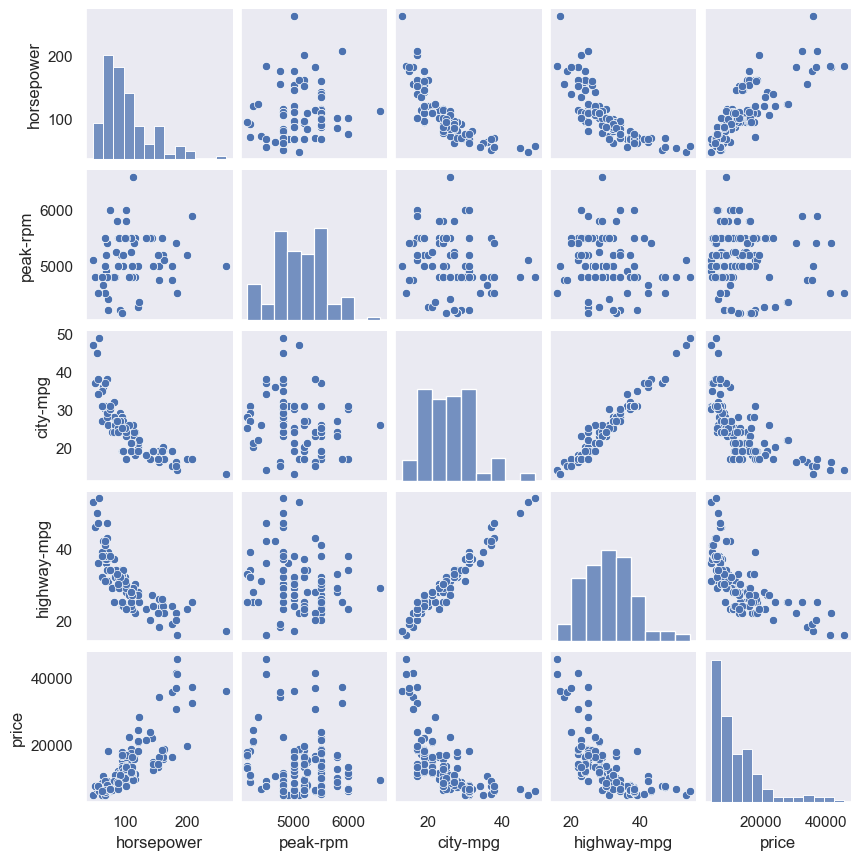

In [8]:
# Display all pairwise correlation coefficients for the columns in the training dataset
display(car_train[["horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"]].corr())

# Graphically examine each pair of features
sns.set_style("dark")
sns.pairplot(
    car_train,
    x_vars = ["horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"],
    y_vars = ["horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"],
    height = 1.75
)
plt.show()

It appears that cars with a higher `price` have **lower** fuel efficiency (as measured by the negative correlation coefficients between `price` and `city-mpg` and `highway-mpg`).

The features `city-mpg` and `highway-mpg` are likely to be most redundant, since they both measure fuel efficiency and have a near-1.0 correlation coefficient ($\approx0.97$).

The feature `peak-rpm` is likely to be the least useful for predicting `price`, since it has a near-zero/the lowest correlation coefficient ($\approx-0.08$).

### Step 8: Build a Model using Tensorflow
We'll use Tensorflow to build a *computational graph* and then send data through it. There are many ways to build graphs, but the [Keras library](https://www.tensorflow.org/api_docs/python/tf/keras) is nice. Here, we'll use [`keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) to create a model layer.

In [9]:
def build_model(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    # Clear extra copies of graph and set seed for results consistency
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential - for linear regression, only need a single layer
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        units=1,                                 # output dim
        input_shape=[num_features],              # input dim
        use_bias=True,                           # use a bias (intercept) param
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
    ))

    # Use mini-batch SGD for optimization
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Compile the model and specify loss function to finalize the graph for training
    model.compile(loss='mse', optimizer=optimizer)
    return model

After we've built a model, we can inspect the initial parameters (weights). There should be two ($w_0$ and $b$) and they should be initialized to 1, which we specified above using `tf.ones_initializer`. Tensorflow stores the bias/intercept separately from the other weights/parameters for the layer.

In [10]:
# Build/initialize a 1-feature model
model = build_model(num_features=1, learning_rate=0.0001)

# Return lists of weights and biases for the layer
weights, biases = model.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

Weights: [[1.]]
Biases: [1.]


2023-01-31 10:29:38.725954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Build/initialize a 2-feature model
model = build_model(num_features=2, learning_rate=0.0001)
weights, biases = model.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

Weights: [[1.]
 [1.]]
Biases: [1.]


### Step 9: Using a Model to Make Predictions
Before training, the parameters are set to their initial values (1s in our case). During training, we use the current predictions to compute a gradient and update the parameter values. Making predictions using the model without updating parameter values is called **Inference**.

In [12]:
# Build a model that expects 1 input feature
model = build_model(num_features=1, learning_rate=0.0001)

# Make a prediction for a single input
print(model.predict([42]))

# Make predictions for 2 inputs
print(model.predict([42, 99]))

1/1 [==============================] - 0s 94ms/step
[[43.]]
1/1 [==============================] - 0s 30ms/step
[[ 43.]
 [100.]]


### Step 10: Train a Model
Let's train an initial model with just 1 feature -- `horsepower`. We can convert the return value into a DataFrame that tracks training metrics (in this case, training data loss and validation data loss) after each *epoch* (a full pass through the training data).

With mini-batch SGD, each time the model estimates the loss for the current weights, it randomly samples a batch of training examples (of the specified size) to do so.

We'll set aside some examples from the training set as a *validation set* to check for overfitting while training. This maintains the purity of the *test set* for final generalization/testing purposes.

In [13]:
model = build_model(num_features=1, learning_rate=0.00001)

history = model.fit(
  x = car_train_features[['horsepower']],
  y = car_train_labels,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=5,
  batch_size=32,
  verbose=0)

# Convert return value into a DataFrame to see loss after each epoch
# History includes training data loss ('loss') and validation data loss ('val_loss')
history = pd.DataFrame(history.history)
display(history)

/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


,loss,val_loss
0,123108368.0,46028052.0
1,29494928.0,24978916.0
2,22284512.0,23706890.0
3,22127404.0,24256636.0
4,22444606.0,24018900.0


## A Quick Note on Feature Scaling
Hmmm. The loss is increasing as we train. This must be because the scale of each feature value is different. Horsepower ranges from 48 to 262, while price ranges from \$5118 to \$45400. These different scales makes it more difficult to set the learning rate, and may make learning nearly impossible when we use multiple features (the scales of the gradients will overwhelm the actual feature importances).

We'll try reducing the learning rate by 10x to 1e-5. That's one way to fix the problem. However, an even better solution is to normalize the features so they are all roughly in the same range.

We'll apply mean and variance normalization to do this. That is, for each feature, we'll subtract the mean (center the distribution on 0) and divide by the standard deviation (set the variance to 1).

### Step 11: Feature Normalization

We'll apply mean and variance normalization to produce `car_train_features_norm` and `car_test_features_norm` (copies of `car_train_features` and `car_test_features`, but with normalized feature values). Note that we do not normalize the labels (prices).

In [14]:
# Apply mean and variance normalization to car_train_features and car_test_features datasets
car_train_features_norm = (car_train_features - car_train_features.mean()) / car_train_features.std()
car_test_features_norm = (car_test_features - car_train_features.mean()) / car_train_features.std()

# Display first 10 rows of updated training dataset with normalization calculations applied
print("Displaying snippet of updated training dataset with normalization applied:")
display(car_train_features_norm.head(10))

print("\n=======================================================================================\n")

# Verify normalized training data looks right
print("Verifying normalized training data looks right with describe table:")
display(car_train_features_norm.describe())

print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

# Display first 10 rows of updated test dataset with normalization calculations applied
print("Displaying snippet of updated test dataset with normalization applied:")
display(car_test_features_norm.head(10))

print("\n=======================================================================================\n")

# Verify normalized test data looks right
print("Verifying normalized test data looks right with describe table:")
display(car_test_features_norm.describe())

Displaying snippet of updated training dataset with normalization applied:


,horsepower,peak-rpm,city-mpg,highway-mpg
52,-0.875514,-0.226149,0.828089,0.981494
181,1.426491,0.202062,-0.976600,-0.988530
5,0.223170,0.844379,-0.976600,-0.847814
18,-1.398697,-0.012043,3.234341,3.092234
188,-0.038421,0.844379,0.076135,0.137198
170,0.380125,-0.654360,-0.224646,-0.144234
76,-0.875514,0.844379,1.730433,1.403642
154,-1.032469,-0.654360,0.226526,0.137198
104,1.531128,0.202062,-0.976600,-0.847814
33,-0.666241,1.914907,0.677698,0.418630




Verifying normalized training data looks right with describe table:


,horsepower,peak-rpm,city-mpg,highway-mpg
count,160.000000,160.000000,1.600000e+02,1.600000e+02
mean,0.000000,0.000000,2.220446e-16,2.331468e-16
std,1.000000,1.000000,1.000000e+00,1.000000e+00
min,-1.398697,-2.046047,-1.878944e+00,-2.114258e+00
25%,-0.823196,-0.654360,-9.765999e-01,-8.478139e-01
50%,-0.221535,-0.012043,-7.425543e-02,-7.387590e-02
75%,0.360506,0.844379,8.280890e-01,8.407781e-01
max,4.199361,3.199541,3.535122e+00,3.232950e+00



+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Displaying snippet of updated test dataset with normalization applied:


,horsepower,peak-rpm,city-mpg,highway-mpg
168,0.380125,-0.654360,-0.224646,-0.144234
127,2.760608,1.700802,-1.277381,-0.847814
180,1.426491,0.202062,-0.826209,-0.988530
32,-1.084787,0.844379,1.880824,1.544358
167,0.380125,-0.654360,-0.224646,-0.144234
142,-0.509286,-1.510783,0.376917,0.277914
204,0.327807,0.630273,-0.976600,-0.847814
147,-0.195376,0.202062,-0.074255,-0.003518
29,1.138741,-0.226149,-0.976600,-0.988530
99,-0.116899,0.202062,0.226526,0.418630




Verifying normalized test data looks right with describe table:


,horsepower,peak-rpm,city-mpg,highway-mpg
count,39.000000,39.000000,39.000000,39.000000
mean,0.257378,0.130694,-0.224646,-0.245261
std,0.888604,1.147576,0.824446,0.778770
min,-1.084787,-1.938994,-1.578163,-1.832826
25%,-0.456968,-0.654360,-0.976600,-0.847814
50%,0.327807,0.202062,-0.224646,-0.144234
75%,0.720194,0.844379,0.226526,0.207556
max,2.760608,3.199541,1.880824,1.544358


### Step 12: Training with Normalized Features
Now we're ready to run some experiments with different sets of input features. We'll start with a simple function that plots train and validation set loss.

In [15]:
def plot_loss(model, history):
    """Plot the loss after each training epoch."""
    # Convert the history object into a DataFrame
    history = pd.DataFrame(history.history)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(history)), history['loss'], marker='.', color='black')
    plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    plt.show()

    # Show the final train loss value and the learned model weights
    print('Final train loss:', list(history['loss'])[-1])
    print('Final validation loss:', list(history['val_loss'])[-1])
    print('Final weights:', model.layers[0].get_weights())

We'll retrain the model predicting price from horsepower, but now with *normalized features*. We can then examine validation loss for various learning rates ([0.0001, 0.001, 0.01, 0.1, 1]) after 150 epochs of training and see which one is best.

/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


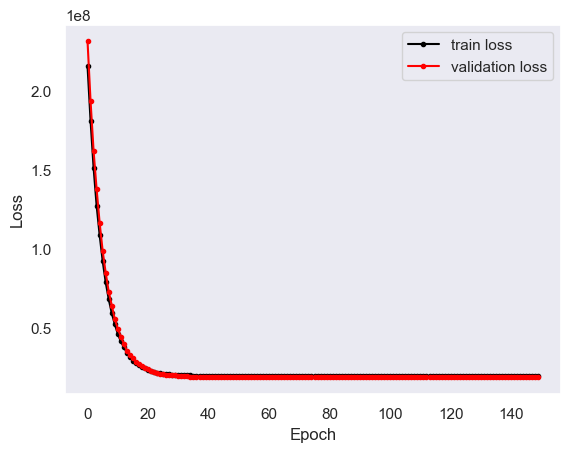

Final train loss: 19829208.0
Final validation loss: 18954012.0
Final weights: [array([[6535.6763]], dtype=float32), array([13029.8955], dtype=float32)]


In [16]:
model = build_model(num_features=1, learning_rate=0.01)

history = model.fit(
  x = car_train_features_norm[['horsepower']],
  y = car_train_labels,
  validation_split=0.1,
  epochs=150,
  batch_size=32,
  verbose=0)

plot_loss(model, history)

Learning Rate | Validation Loss (after 150 epochs of training)
--- | ---
0.0001 | 211,286,080
0.001 | 34,091,168
0.01 | 18,954,012
0.1 | 19,061,412
1 | 399,267,264


**The best validation loss ($\approx1.895\times10^7$) is produced with a learning rate of 0.01.**

### Step 13: Adding Features

The output of the following exercise is a table of RMSE results computed on the test set for our baseline model and four increasingly complex models:
1. features = horsepower
2. features = horsepower, peak-rpm
3. features = horsepower, peak-rpm, highway-mpg
4. features = horsepower, peak-rpm, highway-mpg, city-mpg

For consistency, we'll use a batch size of 32, 150 epochs, and the best learning rate identified above.

/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


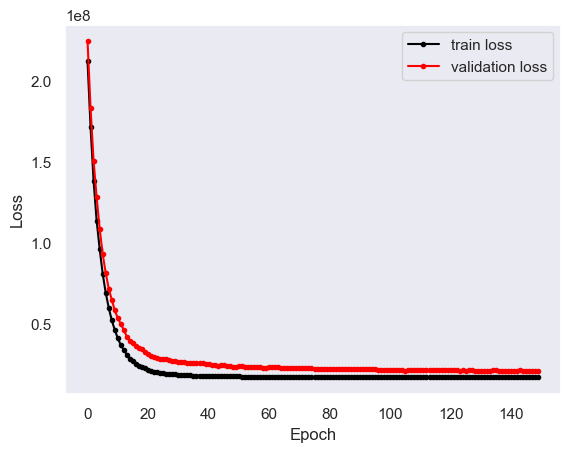

Final train loss: 17292606.0
Final validation loss: 21345758.0
Final weights: [array([[ 5711.921 ],
       [-1503.803 ],
       [-1143.5787],
       [   76.0156]], dtype=float32), array([12997.804], dtype=float32)]
Test rmse: 4982.2298220777


In [17]:
def run_experiment(features, learning_rate):
    model = build_model(len(features), learning_rate)

    history = model.fit(
        x = car_train_features_norm[features],
        y = car_train_labels,
        validation_split=0.1,
        epochs=150,
        batch_size=32,
        verbose=0)
    
    # Plot loss history
    plot_loss(model, history)

    # Make predictions on test data
    test_loss = model.evaluate(
        car_test_features_norm[features],
        car_test_labels,
        verbose=0)
    test_rmse = round(np.sqrt(test_loss),10)
    print('Test rmse:', test_rmse)

run_experiment(['horsepower','peak-rpm','highway-mpg','city-mpg'], 0.01)

Model | Test RMSE
--- | ---
Baseline | 8,018.0007772885
Horsepower | 5,480.3118524405
\+ Peak-RPM | 5,072.5192951826
\+ Highway-MPG | 4,978.6106495688
\+ City-MPG | 4,982.2298220777
